# Tweets Affecting Bitcoin Prices

In this project, we aim to find out if Tweets, or more specifically, words in each Tweet, affect the prices of Bitcoin or not.
The raw data, obtained from Kaggle (https://www.kaggle.com/kaushiksuresh147/bitcoin-tweets), provides us with Tweets with the #BTC or #Bitcoin hashtags from Feb 2021 until Aug 2021.

The 2nd raw data, obtained from FRED Economic Data(https://fred.stlouisfed.org/series/CBBTCUSD), 
Provides us with the prices of Bitcoin (BTC) from Sep 2016 to Sep 2021

Both data will be cleaned and combined before we determine any relationship between them.

Logic: 
1. Finding days with VERY POSITIVE and VERY NEGATIVE price changes.
2. Extracting the keywords that appeared in these days

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import string
import matplotlib.pyplot as plt# Data Clean
import seaborn as sb
import nltk
from nltk.corpus import stopwords
#for wordcloud download
#conda install -c conda-forge wordcloud
from wordcloud import WordCloud

# Bitcoin Tweets

In [2]:
raw_df = pd.read_csv('Bitcoin_tweets.csv', header=0)

#inspect raw data
print('######################     TOP 3 ROWS    ##########################')
print(raw_df.head(3))
print('\n\n######################   BOTTOM 3 ROWS   ##########################')
print(raw_df.tail(3))

C:\Users\nicho\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


######################     TOP 3 ROWS    ##########################
       user_name    user_location  \
0  DeSota Wilson      Atlanta, GA   
1       CryptoND              NaN   
2      Tdlmatias  London, England   

                                    user_description         user_created  \
0  Biz Consultant, real estate, fintech, startups...  2009-04-26 20:05:09   
1  😎 BITCOINLIVE is a Dutch platform aimed at inf...  2019-10-17 20:12:10   
2  IM Academy : The best #forex, #SelfEducation, ...  2014-11-10 10:50:37   

   user_followers user_friends user_favourites user_verified  \
0          8534.0         7605            4838         False   
1          6769.0         1532           25483         False   
2           128.0          332             924         False   

                  date                                               text  \
0  2021-02-10 23:59:04  Blue Ridge Bank shares halted by NYSE after #b...   
1  2021-02-10 23:58:48  😎 Today, that's this #Thursday, we will

In [3]:
raw_df.shape

(1209349, 13)

In [4]:
raw_df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'is_retweet'],
      dtype='object')

In [5]:
# Creating dictionary for date and text only
# e.g. {'date': 'text,text,text', 'date': 'text,text,text'}
date_list = []
dict_1 = {}
true_count = 0
for index, row in raw_df.iterrows():
    # select rows by verified users
    if str(row['user_verified']) == 'True':
        true_count += 1
        if row['date'][0:11] not in date_list:
            
            # add the date to the dictionary as a key
            date_list.append(row['date'][0:11])
            # add the text to the dictionary as a value
            dict_1[date_list[-1]] = row['text']
        else:
            dict_1[row['date'][0:11]] += row['text']    
            
#checking number of keys (dates) in dictionary

date_count = 0

for key, value in dict_1.items():
    date_count += 1            
            
print("There are a total of", true_count, "Tweets made by verified users over", date_count, "dates")

There are a total of 9722 Tweets made by verified users over 76 dates


In [6]:
# convert dictionary to dataframe
shortened_df = pd.DataFrame(list(dict_1.items()),columns = ['date','text']) 

#show shape of new df
print("\nThis is the new shape of the Dataframe", shortened_df.shape)


This is the new shape of the Dataframe (76, 2)


In [7]:
shortened_df.head(10)

,date,text
0,2021-02-10,#Bitcoin’s Rally Signals the Rise of Digital A...
1,2021-02-09,"In just four months, #Bitcoin has climbed from..."
2,2021-02-08,"*As #Bitcoin Hits Record High, Experts Say Oth..."
3,2021-02-07,#Bitcoin mining is horrible for the environmen...
4,2021-02-06,Crypto update:\n#Bitcoin 39790.00 +5.1%\n#Ethe...
5,2021-02-05,#Bitcoin up 8% this week as institutional inve...
6,2021-02-15,Crypto update:\n#Bitcoin 48661.80 -0.41%\n#Eth...
7,2021-02-14,Crypto update:\n#Bitcoin 48824.00 +3.49%\n#Eth...
8,2021-02-13,Being in on the right side of a #crypto bull r...
9,2021-02-19,.@elonmusk has changed his profile picture to ...


# Data Clean

In [8]:
# overview the patterns of text in one day
print(shortened_df['text'].iloc[5])

#Bitcoin up 8% this week as institutional investors continue to pile in. @CoinSharesCo Chief Strategy Officer… https://t.co/PXvYYMu9SmCrypto update:
#Bitcoin 37625.80 -0.14%
#Ether 1708.56 +4.02%
#BitcoinCash 433.08 +0.94%
#EOS 3.1835 +3.67%… https://t.co/VQI6K9fJOnHave you seen our #Bitcoin Analytics Page? 

Learn more about Bitcoin with data points such as on-chain analytics,… https://t.co/KYBSYe2HuIMarket view on TT: #Bitcoin is higher by 2%. #Maker, #ALGO, #COMP, #ZRX, #KNC, #LRC, #OXT and #REP have added more… https://t.co/64k6LEkhqcIt's never too late to start investing in #BTC! Use  @SimplexCC on #Poloniex to buy and sell #crypto using credit /… https://t.co/4aEa8KNmDI⚠ #Crypto Brief ⚠

#Bitcoin #Ethereum #Bitcoinnews #EthereumNews #XBT #BTC #XET

https://t.co/CQ0RDSdQ4ACrypto update:
#Bitcoin 37667.10 -0.03%
#Ether 1665.86 +1.42%
#BitcoinCash 437.86 +2.05%
#EOS 3.1520 +2.65%… https://t.co/KnOHgHZQ1t


In [9]:
# create a function to clean the tweets
def clean_text(text):
    
    # remove @mentions
    #text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # remove the '#' symbol
    #text = re.sub(r'#', '', text)
    # remove the hyper link
    text = re.sub(r'https?:\/\/\S+', '', text)
    # remove punctuations
    text = "".join([char for char in text if char not in string.punctuation])
    # convert text to lowercase
    text = text.lower()
    text = re.sub('[0-9]+','',text)
    text = " ".join(text.split())
             
    return text

# cleaning the text
shortened_df['text'] = shortened_df['text'].apply(lambda x: clean_text(x))

In [10]:
# remove emoji
shortened_df = shortened_df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

In [11]:
# convert date format
shortened_df['date'] = pd.to_datetime(shortened_df.date)

In [12]:
# show clean data
print(shortened_df['text'].iloc[5])

bitcoin up this week as institutional investors continue to pile in coinsharesco chief strategy officer update bitcoin ether bitcoincash eos  you seen our bitcoin analytics page learn more about bitcoin with data points such as onchain analytics view on tt bitcoin is higher by maker algo comp zrx knc lrc oxt and rep have added more never too late to start investing in btc use simplexcc on poloniex to buy and sell crypto using credit  crypto brief  bitcoin ethereum bitcoinnews ethereumnews xbt btc xet update bitcoin ether bitcoincash eos 


# Structured Data

In [13]:
price_df = pd.read_csv('CBBTCUSD.csv')

In [14]:
price_df.head(12)

,FRED Graph Observations,Unnamed: 1
0,Federal Reserve Economic Data,NaN
1,Link: https://fred.stlouisfed.org,NaN
2,Help: https://fredhelp.stlouisfed.org,NaN
3,Economic Research Division,NaN
4,Federal Reserve Bank of St. Louis,NaN
5,NaN,NaN
6,CBBTCUSD,"Coinbase Bitcoin, U.S. Dollars, Daily, Not Sea..."
7,NaN,NaN
8,"Frequency: Daily, 7-Day",NaN
9,observation_date,CBBTCUSD


In [15]:
price_df = price_df.drop(range(0,10))

In [16]:
price_df.columns

Index(['FRED Graph Observations', 'Unnamed: 1'], dtype='object')

In [17]:
# rename columns
price_df = price_df.rename(columns = {'FRED Graph Observations':'date','Unnamed: 1':'price'})

# Convert date format
price_df['date'] = pd.to_datetime(price_df.date)

# convert price to float type
price_df['price'] = pd.Series(price_df['price'], dtype="float")

In [18]:
# create a new column to calculate price change in percentage
price_df['change'] = price_df['price'].pct_change() 
price_df['change'] = price_df['change'] * 100

In [19]:
price_df

,date,price,change
10,2016-01-09,573.02,NaN
11,2016-02-09,576.21,0.556700
12,2016-03-09,600.91,4.286632
13,2016-04-09,611.92,1.832221
14,2016-05-09,605.69,-1.018107
...,...,...,...
1832,2021-08-28,48963.41,-0.241697
1833,2021-08-29,48770.78,-0.393416
1834,2021-08-30,46924.16,-3.786325
1835,2021-08-31,47065.73,0.301700


# Merge Data

In [20]:
print (shortened_df.head(3),"\n\n")
print(type(shortened_df))
print (price_df.head(3))
print(type(price_df))

        date                                               text
0 2021-02-10  bitcoins rally signals the rise of digital ass...
1 2021-02-09  in just four months bitcoin has climbed from u...
2 2021-02-08  as bitcoin hits record high experts say others... 


<class 'pandas.core.frame.DataFrame'>
         date   price    change
10 2016-01-09  573.02       NaN
11 2016-02-09  576.21  0.556700
12 2016-03-09  600.91  4.286632
<class 'pandas.core.frame.DataFrame'>


In [21]:
# merge two dataframes (shortened_df & price_df)
# set date as index 
merge_df = shortened_df.set_index('date').join(price_df.set_index('date'))
print(merge_df.head())
print(merge_df.shape)

                                                         text     price  \
date                                                                      
2021-02-10  bitcoins rally signals the rise of digital ass...       NaN   
2021-02-09  in just four months bitcoin has climbed from u...       NaN   
2021-02-08  as bitcoin hits record high experts say others...  39146.69   
2021-02-07  bitcoin mining is horrible for the environment...  33832.49   
2021-02-06  crypto update bitcoin ether bitcoincash eos st...  37501.36   

              change  
date                  
2021-02-10       NaN  
2021-02-09       NaN  
2021-02-08 -1.682884  
2021-02-07  0.876605  
2021-02-06  2.004048  
(76, 3)


In [22]:
# drop rows with NaN 
merge_df.dropna(subset = ["price"], inplace=True)

In [23]:
# sort dataframe by date
merge_df.sort_values(by ='date')

,text,price,change
date,,,
2021-02-05,bitcoin up this week as institutional investor...,56631.64,-2.138107
2021-02-06,crypto update bitcoin ether bitcoincash eos st...,37501.36,2.004048
2021-02-07,bitcoin mining is horrible for the environment...,33832.49,0.876605
2021-02-08,as bitcoin hits record high experts say others...,39146.69,-1.682884
2021-02-13,being in on the right side of a crypto bull ru...,47274.23,-0.525943
...,...,...,...
2021-08-21,the dollars lost share has been taken up in la...,48896.95,-0.920022
2021-08-23,bitcoin provides a standard global unstoppable...,49464.66,0.276088
2021-08-24,el salvador has adopted bitcoin because of lig...,47770.40,-3.425193


In [24]:
merge_df.to_csv('merge_df.csv')

***

# EDA

In [25]:
merge_df.describe()

,price,change
count,67.000000,67.000000
mean,43261.047612,-0.165007
std,8693.955165,3.703115
min,29788.610000,-10.906904
25%,35247.735000,-2.308674
50%,43933.260000,-0.273826
75%,49816.080000,2.370390
max,59045.170000,8.491473


**price change** <br> max: 8.5% <br> min: -10.9%

Text(0.5, 1.0, 'Count of BTC Price')

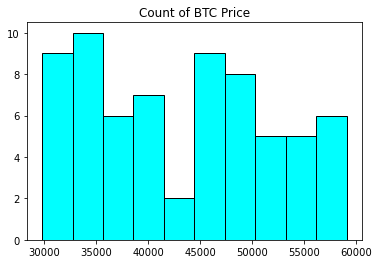

In [26]:
merge_df.hist(column='price', grid=False, edgecolor = 'black', color=['Cyan'])
plt.title('Count of BTC Price')

Text(0.5, 1.0, 'Count of Change Percentage')

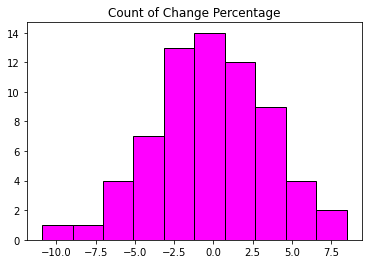

In [27]:
merge_df.hist(column='change', grid=False, edgecolor = 'black', color=['Magenta'])
plt.title('Count of Change Percentage')

# Creation of Unstructured Data for Text Analytics

In [28]:
init_df = pd.read_csv('merge_df.csv', header = 0)
print (init_df.head(3))
print (init_df.tail(3))

         date                                               text     price  \
0  2021-02-08  as bitcoin hits record high experts say others...  39146.69   
1  2021-02-07  bitcoin mining is horrible for the environment...  33832.49   
2  2021-02-06  crypto update bitcoin ether bitcoincash eos st...  37501.36   

     change  
0 -1.682884  
1  0.876605  
2  2.004048  
          date                                               text     price  \
64  2021-08-25  bailliegifford wrote that it has enormous resp...  48985.05   
65  2021-08-24  el salvador has adopted bitcoin because of lig...  47770.40   
66  2021-08-23  bitcoin provides a standard global unstoppable...  49464.66   

      change  
64  2.542683  
65 -3.425193  
66  0.276088  


In [29]:
def convert_to_txt (df):
    #add into a string
    full_txt = []

    for index, row in df.iterrows():
        full_txt.append(str(row[0]) + '\n')
        full_txt.append(str(row[2])  +  '..' + str(round(row[3],3)) + '..' + str(row[1]) + '\n')
    
    #save into .txt file to become Unstructured Data

    f = open('./Unstructured Data.txt','w')

    f.writelines(full_txt)

    f.close()

In [30]:
def txt_to_dict():
    f = open('./Unstructured Data.txt','r')

    full_dict = {}
    quick_key = None

    for line in f:
        if len(line) < 12:
            quick_key = line[:-1]
        
        else:
            full_dict[quick_key] = line.strip().split('..')
            
    return full_dict

In [31]:
#Final format of data prior to running NLTK = { date : price, pricechange, tweets }
import random
convert_to_txt(init_df)
final_unstructured_dict = txt_to_dict()

#TEST PRINT OF ONE RANDOM KEY:VALUE PAIR IN THE DICTIONARY
print(random.choice(list(final_unstructured_dict.items())))

('2021-02-19', ['56029.51', '8.491', 'elonmusk has changed his profile picture to to an image with bitcoin in it what do you think about it another day another record for bitcoin today bitcoin broke btc which represents a gai seems like it is simply unstoppable cryptocurrency crypto btc  new high  bitcoin etc btc cheers  tothestars update bitcoin ether bitcoincash eos  bitcoin may very well continue to be volatile in the short term we think it has x potential from todays are looking for places that could appreciate under the assumption that inflation moves higher and that debt hits yet another alltime peak above last up at btc bitcoin trillion btc market cap achievedis bitcoin going to hit k this year btc cryptocurrency fridaythoughtsbitcoin btc no more words needed  the first time in bitcoins history btc has exceeded a market cap of over trillion usd keep up to date wi reached trillion market cap btc now is same size as apple amazon microsoft and alphabetwe know a thing or two about b

# Text Analytics (NTLK)

In [32]:
# This user-defined function creates a dictionary with the top 20 daily keywords formatted as {keyword 1: [frequency 1, percentage change 1], ...}

def topkeytweets(arb_date): # NLTK 
    
    topKeyWords_dict = {}
    
    word_tokens = nltk.word_tokenize(final_unstructured_dict[arb_date][2]) # tokenize words
    word_tokens = nltk.Text(word_tokens) # tokenized words becomes text

    #Removal of Crypto-related words that appeared several times in both positve & negative days
    removeUnwantedStuff = {'bitcoin', 'btc', 'ether', 'bitcoincash', 'eth', \
                           'litecoin', 'get','amp', 'dogecoin', 'ethereum', \
                           'crypto', 'cryptocurrencies', 'cryptocurrency', \
                           'blockchain', 'financial', 'market', 'trading', \
                           'price', 'money', 'first', 'today', 'k', 'us'}
    
    stop_words = set(stopwords.words('english') + list(removeUnwantedStuff) ) # identify and create own stopwords 
    # print(stop_words) # stop_words
    
    words = [text.lower() for text in word_tokens if not text.lower() in stop_words] # convert all text from your_tokens into lower case and checks if found, otherwise in stop_words

    daily_tweets = nltk.FreqDist(words) # sort words based of the highest frequency 
    
    topKeyWords = {i: daily_tweets[i] for i in list(daily_tweets)[:20]} # top 20 most frequency words from the daily tweets

    for keyword, frequency in topKeyWords.items(): # for loop created to add daily percentage change 
        topKeyWords_dict[keyword] = [frequency, final_unstructured_dict[arb_date][1]] # final_unstructured_dict[arb_date][1] is percent change
        
    return topKeyWords_dict

#Example shown below
topkeytweets('2021-02-08')

{'tesla': [19, '-1.683'],
 'billion': [12, '-1.683'],
 'bought': [7, '-1.683'],
 'update': [5, '-1.683'],
 'buy': [5, '-1.683'],
 'tsla': [5, '-1.683'],
 'high': [4, '-1.683'],
 'eos': [4, '-1.683'],
 'payment': [4, '-1.683'],
 'going': [4, '-1.683'],
 'filing': [4, '-1.683'],
 'record': [3, '-1.683'],
 'teslas': [3, '-1.683'],
 'b': [3, '-1.683'],
 'past': [3, '-1.683'],
 'invests': [3, '-1.683'],
 'accept': [3, '-1.683'],
 'worth': [3, '-1.683'],
 'says': [3, '-1.683'],
 'novogratz': [3, '-1.683']}

# Filtering To Percentiles

To extract the dates where there were meaningful impact on the prices,
We will be looking at the dates where price changes exceeded the interquartile range (eg dropped more than 2.308% or increased more than 2.370%)

In [33]:
# This user-defined function obtains data from final_unstructured_dict in the format as {date 1: [btc price 1, percentage change 1, tweet 1], ...}
# Outputs into 3 lists depending on the percent change of BTC price that day (below 25th percentile, above 75th percentile or others)
# Creates a dictionary for the respectively list formatted as {keyword 1: [frequency 1, percentage change 1], ...}

seventyfive_percentile_list = []
twentyfive_percentile_list = [] 
interquartile_range_list = [] 

for date, btc_perc_dtweet in final_unstructured_dict.items(): # filter date, percentage change, and daily tweets into the respective lists above based on percentiles
    if float(btc_perc_dtweet[1]) >= 2.370390: # btc_perc_dtweet[1] is the daily percentage change  
        seventyfive_percentile_list.append(topkeytweets(date)) # user-defined function from above 
    elif float(btc_perc_dtweet[1]) <= -2.308674: 
        twentyfive_percentile_list.append(topkeytweets(date))
    elif float(btc_perc_dtweet[1]) > -2.308674 and float(btc_perc_dtweet[1]) < 2.370390:
        interquartile_range_list.append(topkeytweets(date))

#Output of each item in the list is a dictionary formatted as {keyword 1: [frequency 1, percent change 1], ...}
#Example shown below
print(seventyfive_percentile_list[0])

{'update': [5, '3.023'], 'eos': [5, '3.023'], 'record': [2, '3.023'], 'higher': [2, '3.023'], 'trade': [2, '3.023'], 'much': [2, '3.023'], 'everyones': [2, '3.023'], 'valentines': [2, '3.023'], 'day': [2, '3.023'], 'pay': [2, '3.023'], 'approaches': [1, '3.023'], 'wider': [1, '3.023'], 'adoption': [1, '3.023'], 'fuels': [1, '3.023'], 'rally': [1, '3.023'], 'predict': [1, '3.023'], 'phrase': [1, '3.023'], 'fun': [1, '3.023'], 'staying': [1, '3.023'], 'poor': [1, '3.023']}


In [34]:
# Using the lists above as the input, extract the keywords for each day in the list and compile into a complete list
# Outputs into 3 lists depending on the percent change of BTC price that day (below 25th percentile, above 75th percentile or others)

def keyword_list(input_list): # Create keyword list for the respective percentiles 
    
    output_keyword_list = [] 

    for keyword_freq_perc_dict in input_list: 
        for keyword in keyword_freq_perc_dict.keys(): # extract the keyword from the input list 
            if keyword in output_keyword_list: # pass if keyword is inside output_keyword_list
                pass
            else: 
                output_keyword_list.append(keyword) # append if keyword is not inside output_keyword_list
    
    return output_keyword_list

# Keyword list for below 25th percentile, above 75th percentile or others 
seventyfive_percentile_keyword_list = keyword_list(seventyfive_percentile_list) # Keyword list for seventy five percentile 
twentyfive_percentile_keyword_list = keyword_list(twentyfive_percentile_list) # Keyword list for twenty five percentile 
interquartile_range_keyword_list = keyword_list(interquartile_range_list) # Keyword list for interquartile range

#Example shown below
print(seventyfive_percentile_keyword_list)

['update', 'eos', 'record', 'higher', 'trade', 'much', 'everyones', 'valentines', 'day', 'pay', 'approaches', 'wider', 'adoption', 'fuels', 'rally', 'predict', 'phrase', 'fun', 'staying', 'poor', 'trillion', 'high', 'new', 'hits', 'cap', 'time', 'another', 'alltime', 'aths', 'elonmusk', 'think', 'etc', 'well', 'continue', 'history', 'mining', 'vntw', 'government', 'bax', 'ada', 'believe', 'caruso', 'accept', 'town', 'centers', 'residences', 'offices', 'outdoor', 'malls', 'apartments', 'luxury', 'resor', 'small', 'holdings', 'route', 'back', 'fund', 'tesla', 'like', 'defi', 'china', 'says', 'know', 'el', 'bitcoins', 'learn', 'markets', 'crackdown', 'energy', 'latest', 'make', 'since', 'january', 'dont', 'cryptocrash', 'level', 'chinas', 'year', 'buy', 'going', 'chinese', 'future', 'still', 'difficulty', 'use', 'youre', 'next', 'fintech', 'got', 'code', 'stellar', 'index', 'bch', 'xlm', 'app', 'olympicgames', 'tokyo', 'olympics', 'covidvaccine', 'tokyoolympics', 'olympic', 'opening', 'op

In [35]:
#Takes in the keyword list and the dictionary to compile another dictionary as format {keyword : [[freq1, % change1], [freq2, % change2].....}

def keyword_freq_perc(keyword_list, input_list): # Create keyword, frequency, and percentage change dictionary for the respective percentiles 

    keyword_freq_perc_dict = {}

    for keyword in keyword_list: 

        combine_list = [] 
        
        for key_freq_perc_dict in input_list: 
            for key, freq_perc in key_freq_perc_dict.items():
                if keyword == key: 
                    combine_list.append(freq_perc)
        
        keyword_freq_perc_dict[keyword] = combine_list
        
    return keyword_freq_perc_dict

seventyfive_percentile_keyword_freq_perc_dict = keyword_freq_perc(seventyfive_percentile_keyword_list, seventyfive_percentile_list) # Keyword, frequency, and percentage change dictionary for seventy five percentile
twentyfive_percentile_keyword_freq_perc_dict = keyword_freq_perc(twentyfive_percentile_keyword_list, twentyfive_percentile_list) # Keyword, frequency, and percentage change dictionary for twenty five percentile
interquartile_range_keyword_freq_perc_dict = keyword_freq_perc(interquartile_range_keyword_list, interquartile_range_list) # Keyword, frequency, and percentage change dictionary for interquartile range 


#Example of one list is shown below
seventyfive_percentile_keyword_freq_perc_dict

{'update': [[5, '3.023'],
  [3, '8.491'],
  [5, '3.82'],
  [5, '3.189'],
  [3, '2.913'],
  [2, '3.836']],
 'eos': [[5, '3.023'], [4, '8.491'], [5, '3.82'], [4, '3.189'], [2, '3.836']],
 'record': [[2, '3.023'], [3, '8.491']],
 'higher': [[2, '3.023']],
 'trade': [[2, '3.023'], [8, '5.594']],
 'much': [[2, '3.023'], [11, '3.63']],
 'everyones': [[2, '3.023']],
 'valentines': [[2, '3.023']],
 'day': [[2, '3.023'],
  [2, '8.491'],
  [17, '2.593'],
  [5, '3.82'],
  [11, '4.474'],
  [10, '2.543']],
 'pay': [[2, '3.023']],
 'approaches': [[1, '3.023']],
 'wider': [[1, '3.023']],
 'adoption': [[1, '3.023']],
 'fuels': [[1, '3.023']],
 'rally': [[1, '3.023']],
 'predict': [[1, '3.023']],
 'phrase': [[1, '3.023']],
 'fun': [[1, '3.023']],
 'staying': [[1, '3.023']],
 'poor': [[1, '3.023']],
 'trillion': [[7, '8.491']],
 'high': [[5, '8.491']],
 'new': [[4, '8.491'],
  [8, '3.82'],
  [6, '5.374'],
  [10, '5.594'],
  [10, '4.474'],
  [18, '2.543']],
 'hits': [[4, '8.491']],
 'cap': [[4, '8.491'],

# Unstructured To Structured Data

In [36]:
# Convert dictionary into dataframe
def dict_to_df(keyword_freq_perc_dict):
    dict_to_list = list(keyword_freq_perc_dict.items())
    int_df = pd.DataFrame(np.array(dict_to_list), columns = ['Words', 'Frequency & % Change'])
    return int_df

seventyfive_percentile_df = dict_to_df(seventyfive_percentile_keyword_freq_perc_dict) # structured seventy five percentile dataframe
twentyfive_percentile_df = dict_to_df(twentyfive_percentile_keyword_freq_perc_dict) # structured seventy five percentile dataframe
interquartile_range_df = dict_to_df(interquartile_range_keyword_freq_perc_dict) # structured seventy five percentile dataframe

<ipython-input-36-396130def575>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  int_df = pd.DataFrame(np.array(dict_to_list), columns = ['Words', 'Frequency & % Change'])


In [37]:
seventyfive_percentile_df 

,Words,Frequency & % Change
0,update,"[[5, 3.023], [3, 8.491], [5, 3.82], [5, 3.189]..."
1,eos,"[[5, 3.023], [4, 8.491], [5, 3.82], [4, 3.189]..."
2,record,"[[2, 3.023], [3, 8.491]]"
3,higher,"[[2, 3.023]]"
4,trade,"[[2, 3.023], [8, 5.594]]"
...,...,...
217,last,"[[11, 2.543]]"
218,futures,"[[11, 2.543]]"
219,real,"[[9, 2.543]]"
220,company,"[[9, 2.543]]"


In [38]:
freq_occurence = seventyfive_percentile_df['Frequency & % Change']

###############################################################################
#retrieve total sum of frequency in "Frequency & % Change" for each row

#count_of_freq to hold the length of each element in the "Frequency & % Change" column
count_of_freq = []
for instance in freq_occurence:
    count_of_freq.append((len(instance)))

# print(count_of_freq)

#counter to hold the word occurence frequency in each element of the "Frequency & % Change" column
counter = []
for instance in freq_occurence:
    for pair in instance:
        counter.append(pair[0])

# print(counter)

#counter to hold the sum of total word occurence frequency for each element of the "Frequency & % Change" column
new_counter = []
for i in count_of_freq:
    freqsum = sum(counter[:i])
    new_counter.append(freqsum)
    del counter[:i]

# print(new_counter)
###############################################################################

#retrieve total sum of % Change in "Frequency & % Change" for each row

percentchange = []
for instance in freq_occurence:
    for pair in instance:
        percentchange.append(float(pair[1]))

# print(percentchange)

new_percentchange = []
for i in count_of_freq:
    totalpercentchange_perword = sum(percentchange[:i])
    new_percentchange.append(totalpercentchange_perword)
    del percentchange[:i]

# print(new_percentchange)
###############################################################################

#appending new columns in the dataframe
seventyfive_percentile_df['Frequency & % Change (Count of pairs)'] = count_of_freq

seventyfive_percentile_df['Frequency (Sum)'] = new_counter
seventyfive_percentile_df['Frequency (Mean)'] = seventyfive_percentile_df['Frequency (Sum)'] / seventyfive_percentile_df['Frequency & % Change (Count of pairs)']

seventyfive_percentile_df['% Change (Sum)'] = new_percentchange
seventyfive_percentile_df['% Change (Mean)'] = seventyfive_percentile_df['% Change (Sum)'] / seventyfive_percentile_df['Frequency & % Change (Count of pairs)']

seventyfive_percentile_df.drop(columns = ['Frequency & % Change'],inplace = True)
structured_seventyfive_percentile_df = seventyfive_percentile_df

structured_seventyfive_percentile_df

,Words,Frequency & % Change (Count of pairs),Frequency (Sum),Frequency (Mean),% Change (Sum),% Change (Mean)
0,update,6,23,3.833333,25.272,4.2120
1,eos,5,20,4.000000,22.359,4.4718
2,record,2,5,2.500000,11.514,5.7570
3,higher,1,2,2.000000,3.023,3.0230
4,trade,2,10,5.000000,8.617,4.3085
...,...,...,...,...,...,...
217,last,1,11,11.000000,2.543,2.5430
218,futures,1,11,11.000000,2.543,2.5430
219,real,1,9,9.000000,2.543,2.5430
220,company,1,9,9.000000,2.543,2.5430


In [39]:
freq_occurence2 = twentyfive_percentile_df['Frequency & % Change']

###############################################################################
#retrieve total sum of frequency in "Frequency & % Change" for each row

#count_of_freq to hold the length of each element in the "Frequency & % Change" column
count_of_freq2 = []
for instance in freq_occurence2:
    count_of_freq2.append((len(instance)))

# print(count_of_freq)

#counter to hold the word occurence frequency in each element of the "Frequency & % Change" column
counter2 = []
for instance in freq_occurence2:
    for pair in instance:
        counter2.append(pair[0])

# print(counter)

#counter to hold the sum of total word occurence frequency for each element of the "Frequency & % Change" column
new_counter2 = []
for i in count_of_freq2:
    freqsum2 = sum(counter2[:i])
    new_counter2.append(freqsum2)
    del counter2[:i]

# print(new_counter)
###############################################################################
#retrieve total sum of % Change in "Frequency & % Change" for each row

percentchange2 = []
for instance in freq_occurence2:
    for pair in instance:
        percentchange2.append(float(pair[1]))

# print(percentchange)

new_percentchange2 = []
for i in count_of_freq2:
    totalpercentchange_perword2 = sum(percentchange2[:i])
    new_percentchange2.append(totalpercentchange_perword2)
    del percentchange2[:i]

# print(new_percentchange)
###############################################################################
#appending new columns in the dataframe
twentyfive_percentile_df['Frequency & % Change (Count of pairs)'] = count_of_freq2

twentyfive_percentile_df['Frequency (Sum)'] = new_counter2
twentyfive_percentile_df['Frequency (Mean)'] = twentyfive_percentile_df['Frequency (Sum)'] / twentyfive_percentile_df['Frequency & % Change (Count of pairs)']

twentyfive_percentile_df['% Change (Sum)'] = new_percentchange2
twentyfive_percentile_df['% Change (Mean)'] = twentyfive_percentile_df['% Change (Sum)'] / twentyfive_percentile_df['Frequency & % Change (Count of pairs)']

twentyfive_percentile_df.drop(columns = ['Frequency & % Change'],inplace = True)
structured_twentyfive_percentile_df = twentyfive_percentile_df

In [40]:
structured_twentyfive_percentile_df

,Words,Frequency & % Change (Count of pairs),Frequency (Sum),Frequency (Mean),% Change (Sum),% Change (Mean)
0,dip,2,7,3.5,-9.133,-4.5665
1,billion,2,13,6.5,-9.348,-4.6740
2,way,1,3,3.0,-5.923,-5.9230
3,bank,3,6,2.0,-17.265,-5.7550
4,started,1,2,2.0,-5.923,-5.9230
...,...,...,...,...,...,...
218,salvador,1,9,9.0,-3.425,-3.4250
219,hold,1,8,8.0,-3.425,-3.4250
220,payments,1,8,8.0,-3.425,-3.4250
221,microstrategy,1,8,8.0,-3.425,-3.4250


# Data Visualisation and Insights

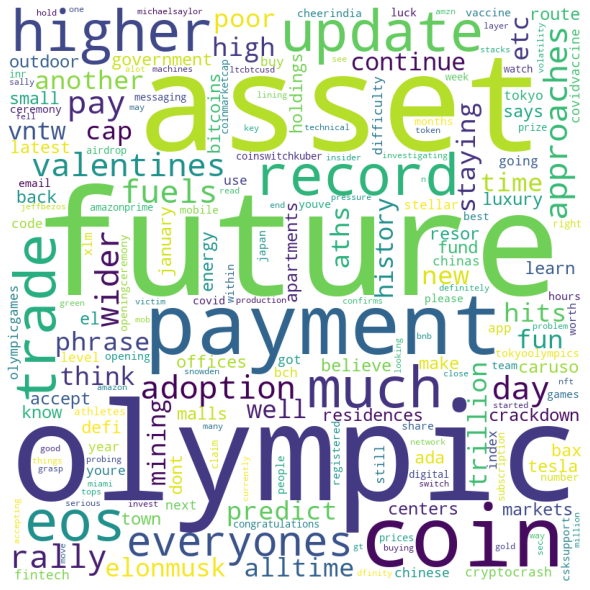

In [75]:
comment_words = ''

for val in structured_seventyfive_percentile_df['Words']:
    
    # split the words into individual lists
    tokens = val.split()
    
    # to ensure all strings are separated by space
    comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(comment_words)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

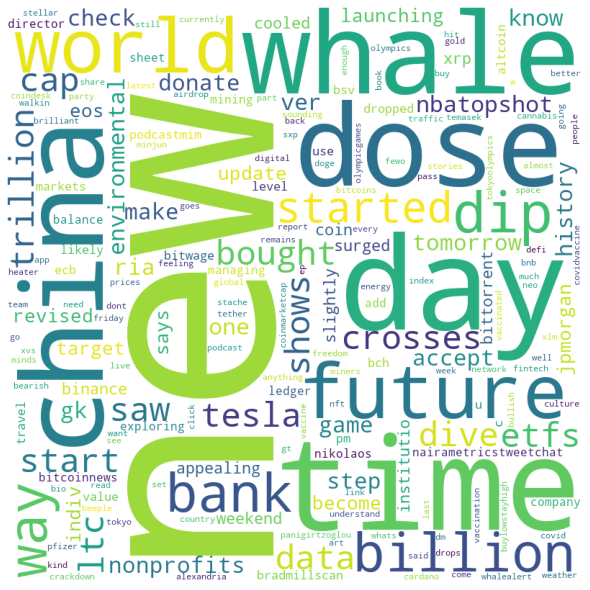

In [42]:
comment_words2 = ''

for val in structured_twentyfive_percentile_df['Words']:
    
    # split the words into individual lists
    tokens = val.split()
    
    # to ensure all strings are separated by space
    comment_words2 += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(comment_words2)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

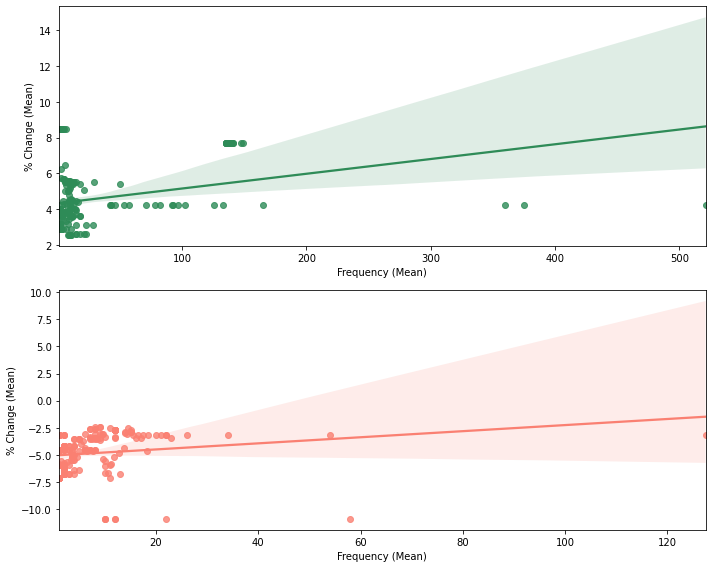

In [57]:
fig, ax =plt.subplots(2,1)

sb.regplot(y='% Change (Mean)', x='Frequency (Mean)', data=structured_seventyfive_percentile_df, scatter=True, color = "seagreen", ax=ax[0])

sb.regplot(y='% Change (Mean)', x='Frequency (Mean)', data=structured_twentyfive_percentile_df, scatter=True, color = "salmon", ax=ax[1])

plt.rcParams['figure.figsize'] = [10, 7]
plt.tight_layout()
plt.show()

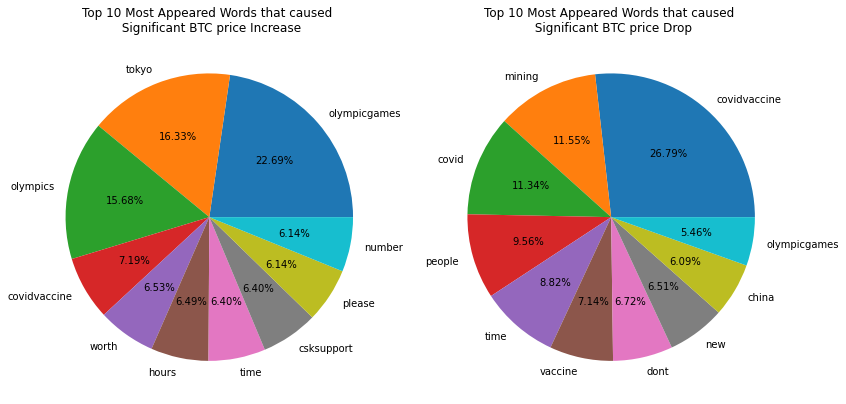

In [44]:
#top 10 words by frequency (Sum):

fig, ax =plt.subplots(1,2)

structured_seventyfive_percentile_df_top10sum = structured_seventyfive_percentile_df.nlargest(10, 'Frequency (Sum)')

structured_seventyfive_percentile_df_top10sum.plot(kind='pie', y = 'Frequency (Sum)', autopct='%1.2f%%', figsize=(12, 12), ylabel='', labels = structured_seventyfive_percentile_df_top10sum["Words"], legend= None, ax=ax[0])
ax[0].set_title("Top 10 Most Appeared Words that caused \n Significant BTC price Increase")

######################################################################################################################################################################

structured_twentyfive_percentile_df_top10drop = structured_twentyfive_percentile_df.nlargest(10, 'Frequency (Sum)')

structured_twentyfive_percentile_df_top10drop.plot(kind='pie', y = 'Frequency (Sum)', autopct='%1.2f%%', figsize=(12, 12), ylabel='', labels = structured_twentyfive_percentile_df_top10drop["Words"], legend= None, ax=ax[1])
ax[1].set_title("Top 10 Most Appeared Words that caused \n Significant BTC price Drop")

plt.tight_layout()
plt.show()

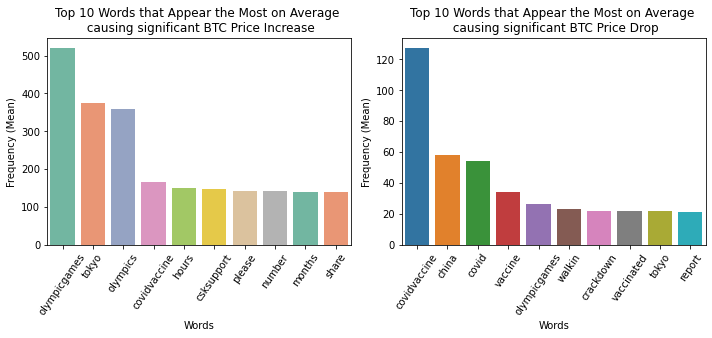

In [45]:
#top 10 words by frequency (Mean):
fig, ax =plt.subplots(1,2)

structured_seventyfive_percentile_df2 = structured_seventyfive_percentile_df.nlargest(10, 'Frequency (Mean)')
structured_seventyfive_percentile_df2 = structured_seventyfive_percentile_df2[["Words", 'Frequency (Mean)', "% Change (Mean)"]]
sb.barplot(data=structured_seventyfive_percentile_df2, x="Words", y="Frequency (Mean)", palette= "Set2", ax=ax[0])
ax[0].set_title("Top 10 Words that Appear the Most on Average \n causing significant BTC Price Increase")
ax[0].set_xticklabels(structured_seventyfive_percentile_df2["Words"], rotation=55)
    
structured_twentyfive_percentile_df2 = structured_twentyfive_percentile_df.nlargest(10, 'Frequency (Mean)')
structured_twentyfive_percentile_df2 = structured_twentyfive_percentile_df2[["Words", 'Frequency (Mean)', "% Change (Mean)"]]
sb.barplot(data=structured_twentyfive_percentile_df2, x="Words", y="Frequency (Mean)", ax=ax[1])
ax[1].set_title("Top 10 Words that Appear the Most on Average \n causing significant BTC Price Drop")

plt.xticks(rotation=55)
plt.tight_layout()

Text(0.5, 1.0, 'Range of % Decrease that Occurs Most Often')

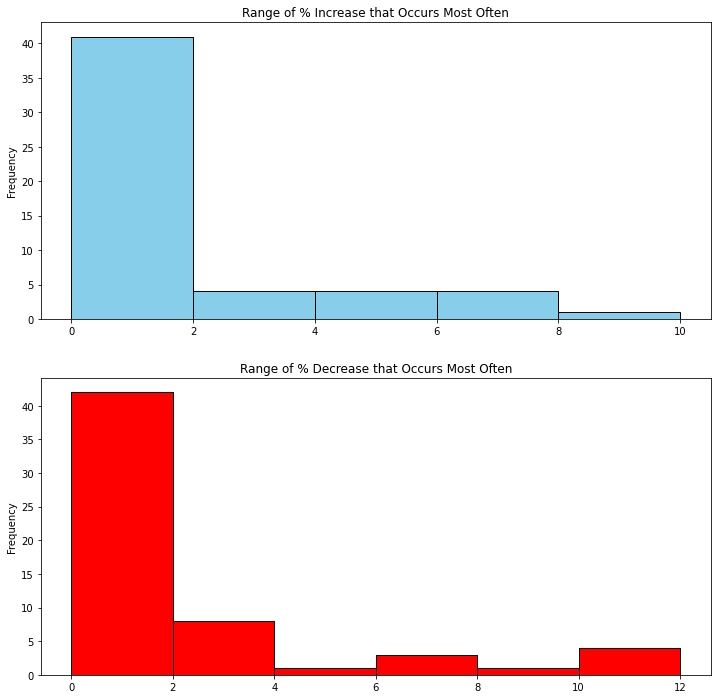

In [46]:
#to determine which range of % change in BTC price is most common:

fig, ax =plt.subplots(2,1)

structured_seventyfive_percentile_df["% Change (Mean)"].value_counts().plot(kind='hist', figsize=(12, 12), bins=[0,2,4,6,8,10], color="skyblue", edgecolor="k", ax=ax[0])
ax[0].set_title("Range of % Increase that Occurs Most Often")

structured_twentyfive_percentile_df["% Change (Mean)"].value_counts().plot(kind='hist', figsize=(12, 12), bins=[0,2,4,6,8,10,12], color="red", edgecolor="k", ax=ax[1])
ax[1].set_title("Range of % Decrease that Occurs Most Often")


In [47]:
#top 10 words by % Increase (Mean):

structured_seventyfive_percentile_df3 = structured_seventyfive_percentile_df.nlargest(10, '% Change (Mean)') 
structured_seventyfive_percentile_df3 = structured_seventyfive_percentile_df3[["Words", "% Change (Mean)", "Frequency (Mean)"]]
structured_seventyfive_percentile_df3

,Words,% Change (Mean),Frequency (Mean)
20,trillion,8.491,7.0
21,high,8.491,5.0
23,hits,8.491,4.0
26,another,8.491,3.0
27,alltime,8.491,3.0
28,aths,8.491,3.0
29,elonmusk,8.491,2.0
31,etc,8.491,2.0
32,well,8.491,2.0
33,continue,8.491,2.0


In [48]:
#top 10 words by % Decrease (Mean):
structured_twentyfive_percentile_df3 = structured_twentyfive_percentile_df.nsmallest(10, '% Change (Mean)')
structured_twentyfive_percentile_df3 = structured_twentyfive_percentile_df3[["Words", "% Change (Mean)", "Frequency (Mean)"]]
structured_twentyfive_percentile_df3

,Words,% Change (Mean),Frequency (Mean)
132,china,-10.907,58.0
133,crackdown,-10.907,22.0
140,miners,-10.907,12.0
142,chinas,-10.907,12.0
146,live,-10.907,10.0
147,go,-10.907,10.0
148,last,-10.907,10.0
138,bitcoins,-7.166,11.0
40,revised,-7.139,1.0
41,target,-7.139,1.0


In [49]:
#to determine common words that cause both significant increase and decrease in BTC price

averageonly_seventyfive = structured_seventyfive_percentile_df[["Words", "% Change (Mean)", "Frequency (Mean)"]]
averageonly_twentyfive = structured_twentyfive_percentile_df[["Words", "% Change (Mean)", "Frequency (Mean)"]]

averageonly_seventyfive
wordsincommon = []

for commonword in averageonly_seventyfive["Words"]:
    for commonword2 in averageonly_twentyfive["Words"]:
        if commonword == commonword2:
            wordsincommon.append(commonword)
            
print(wordsincommon)

totalcountofcommon = len(wordsincommon)
print(f" There are a total of {totalcountofcommon} words in common.")

['update', 'eos', 'much', 'day', 'trillion', 'new', 'cap', 'time', 'well', 'history', 'mining', 'accept', 'back', 'tesla', 'like', 'defi', 'china', 'says', 'know', 'bitcoins', 'markets', 'crackdown', 'energy', 'latest', 'make', 'since', 'dont', 'level', 'chinas', 'buy', 'going', 'future', 'still', 'use', 'fintech', 'stellar', 'index', 'bch', 'xlm', 'app', 'olympicgames', 'tokyo', 'olympics', 'covidvaccine', 'tokyoolympics', 'team', 'covid', 'vaccine', 'people', 'share', 'airdrop', 'digital', 'coinmarketcap', 'would', 'week', 'prices', 'one', 'payments', 'gt', 'hold', 'way', 'see', 'gold', 'bnb', 'started', 'network', 'currently', 'read', 'nft', 'million', 'need', 'coin', 'value', 'last', 'futures', 'company']
 There are a total of 76 words in common.


# Conclusion

From the data that we have obtained, we were able to to get a better understanding of how the occurence of some words are linked to the increase in decrease in price. 

Some very positive words that have a stronger relationship to Bitcoin prices are words that are linked to Time and words linked to the Tokyo Olympics. Conversely, words that have a negative impact are words related to China and Covid.

# Limitations & Potential Development Areas

There were a few limitations in our project.
1. The timeline was relatively short (6 months), datapoints not as much after filtering
2. Context of the words in the sentence cannot be interpreted (eg "BUY" vs "DONT BUY")
3. There could be effects of tweets (from significant events) that lasts beyond 1 day
4. The keywords that were excluded from the results were subjective (eg Bitcoin, cryptocurrency etc)

Future Potential Development Areas:
1. Possible Further Development into the project could look into exploring codes that resolves Limitation 2 and 3.
2. Using the results obtained, models could also be made to project possible price changes from the occurance of words in a word group, if a more causative relationship could be established. 
3. Topic Modelling with Latent Dirichlet Allocation (LDA) could be employed to get a more definitive sentiment analysis based on phrases as well.